## 데이터 불러오기

In [ ]:
# torch, torch-geometric 설치
!pip install torch
!pip install torch-geometric

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
import matplotlib.pyplot as plt
import torch.nn as nn
from torch_geometric.nn import SAGEConv, to_hetero
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc
import random


data_path = "/content/drive/MyDrive/졸업과제/"

gene = pd.read_csv(data_path + "gene_processed.csv")
disease = pd.read_csv(data_path + "disease_processed.csv")
gda = pd.read_csv(data_path + "gda_processed.csv")

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)  # CPU 연산용 시드 설정
    torch.cuda.manual_seed(seed)  # GPU 연산용 시드 설정
    torch.cuda.manual_seed_all(seed)  # 모든 GPU의 연산 시드 설정 (멀티-GPU 환경일 경우)
    np.random.seed(seed)  # numpy 시드 설정
    random.seed(seed)  # 파이썬의 random 모듈 시드 설정


    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


## 그래프 구성

In [ ]:
data = HeteroData()

# 유전자, 질병 노드 추가
data["gene"].x = torch.tensor(gene.loc[:, gene.columns!="geneId"].values, dtype=torch.float32)
data["disease"].x = torch.tensor(disease.loc[:, disease.columns!="diseaseId"].values, dtype=torch.float32)

# id를 인덱스로 변환
gda_index = pd.DataFrame({"geneIndex" : gda["geneId"].map(gene.set_index("geneId").index.get_loc),
                         "diseaseIndex" : gda["diseaseId"].map(disease.set_index("diseaseId").index.get_loc)}).transpose()

gene_index_map = {gene_id: index for index, gene_id in enumerate(gene['geneId'])}
disease_index_map = {disease_id: index for index, disease_id in enumerate(disease['diseaseId'])}
index_gene_map = {index: gene_id for gene_id, index in gene_index_map.items()}
index_disease_map = {index: disease_id for disease_id, index in disease_index_map.items()}

# 유전자-질병, 질병-유전자 엣지 추가
data["gene", "associations", "disease"].edge_index = torch.tensor(gda_index.values)
data = T.ToUndirected()(data)

data

HeteroData(
  gene={ x=[15576, 32] },
  disease={ x=[30170, 32] },
  (gene, associations, disease)={ edge_index=[2, 74775] },
  (disease, rev_associations, gene)={ edge_index=[2, 74775] }
)

In [ ]:
set_seed(42)
# 데이터 분할
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    is_undirected=True,
    disjoint_train_ratio=0.3,
    neg_sampling_ratio=1.25,
    add_negative_train_samples=True,
    edge_types=[("gene", "associations","disease")],
    rev_edge_types=[("disease", "rev_associations", "gene")]
)(data)

print("--- Training Data ---")
print(train_data)
print("--- Validation Data ---")
print(val_data)
print("--- Test Data ---")
print(test_data)

--- Training Data ---
HeteroData(
  gene={ x=[15576, 32] },
  disease={ x=[30170, 32] },
  (gene, associations, disease)={
    edge_index=[2, 41875],
    edge_label=[40378],
    edge_label_index=[2, 40378],
  },
  (disease, rev_associations, gene)={ edge_index=[2, 41875] }
)
--- Validation Data ---
HeteroData(
  gene={ x=[15576, 32] },
  disease={ x=[30170, 32] },
  (gene, associations, disease)={
    edge_index=[2, 59821],
    edge_label=[16823],
    edge_label_index=[2, 16823],
  },
  (disease, rev_associations, gene)={ edge_index=[2, 59821] }
)
--- Test Data ---
HeteroData(
  gene={ x=[15576, 32] },
  disease={ x=[30170, 32] },
  (gene, associations, disease)={
    edge_index=[2, 67298],
    edge_label=[16823],
    edge_label_index=[2, 16823],
  },
  (disease, rev_associations, gene)={ edge_index=[2, 67298] }
)


## 모델

In [ ]:
class GCN(nn.Module):
  def __init__(self, h_dim):
    super().__init__()
    self.conv1 = SAGEConv((-1,-1), h_dim)
    self.conv2 = SAGEConv((-1,-1), h_dim)
    self.conv3 = SAGEConv((-1,-1), h_dim)
    self.conv4 = SAGEConv((-1,-1), h_dim)

  def forward(self, x_dict, edge_index_dict):
    x_dict = self.conv1(x_dict, edge_index_dict).relu()
    x_dict = self.conv2(x_dict, edge_index_dict).relu()
    x_dict = self.conv3(x_dict, edge_index_dict).relu()
    x_dict = self.conv4(x_dict, edge_index_dict)
    return x_dict

class Classifier(nn.Module):
  def forward(self, x_dict, edge_label_index):
    edge_feat_gene = x_dict["gene"][edge_label_index[0]]
    edge_feat_disease = x_dict["disease"][edge_label_index[1]]
    return (edge_feat_gene * edge_feat_disease).sum(dim=-1)

class Model(nn.Module):
  def __init__(self, h_dim):
        super().__init__()

        self.gcn = GCN(h_dim)
        self.gcn = to_hetero(self.gcn, data.metadata())
        self.classifier = Classifier()

  def forward(self, data):
      x_dict = {
          "gene":data["gene"].x,
          "disease":data["disease"].x
      }

      x_dict = self.gcn(x_dict, data.edge_index_dict)

      output = self.classifier(
          x_dict,
          data["gene", "associations", "disease"].edge_label_index,
      )

      return output

In [ ]:
model = Model(32)
model

Model(
  (gcn): GraphModule(
    (conv1): ModuleDict(
      (gene__associations__disease): SAGEConv((-1, -1), 32, aggr=mean)
      (disease__rev_associations__gene): SAGEConv((-1, -1), 32, aggr=mean)
    )
    (conv2): ModuleDict(
      (gene__associations__disease): SAGEConv((-1, -1), 32, aggr=mean)
      (disease__rev_associations__gene): SAGEConv((-1, -1), 32, aggr=mean)
    )
    (conv3): ModuleDict(
      (gene__associations__disease): SAGEConv((-1, -1), 32, aggr=mean)
      (disease__rev_associations__gene): SAGEConv((-1, -1), 32, aggr=mean)
    )
    (conv4): ModuleDict(
      (gene__associations__disease): SAGEConv((-1, -1), 32, aggr=mean)
      (disease__rev_associations__gene): SAGEConv((-1, -1), 32, aggr=mean)
    )
  )
  (classifier): Classifier()
)

In [ ]:
#set_seed(42)

model = Model(32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    pred = model(train_data)
    ground_truth = train_data["gene", "associations", "disease"].edge_label
    loss = F.binary_cross_entropy_with_logits(pred, ground_truth)
    loss.backward()
    optimizer.step()
    return float(loss)

def test(specific_gene_id=None):
    model.eval()

    # 학습된 모델 값 받아오기
    train_pred_logits = model(train_data).detach()
    val_pred_logits = model(val_data).detach()
    test_pred_logits = model(test_data).detach()

    # Sigmoid 변환
    train_pred = torch.sigmoid(train_pred_logits).numpy()
    val_pred = torch.sigmoid(val_pred_logits).numpy()
    test_pred = torch.sigmoid(test_pred_logits).numpy()

    # 정답 셋
    train_gt = train_data["gene", "associations", "disease"].edge_label.detach().numpy()
    val_gt = val_data["gene", "associations", "disease"].edge_label.detach().numpy()
    test_gt = test_data["gene", "associations", "disease"].edge_label.detach().numpy()

    # 0.5를 기준으로 이진 분류
    train_pred_bin = (train_pred >= 0.5).astype(int)
    val_pred_bin = (val_pred >= 0.5).astype(int)
    test_pred_bin = (test_pred >= 0.5).astype(int)

    # Accuarcy 측정
    train_acc = accuracy_score(train_gt, train_pred_bin)
    val_acc = accuracy_score(val_gt, val_pred_bin)
    test_acc = accuracy_score(test_gt, test_pred_bin)

    # AUROC 측정
    train_auroc = roc_auc_score(train_gt, train_pred)
    val_auroc = roc_auc_score(val_gt, val_pred)
    test_auroc = roc_auc_score(test_gt, test_pred)

    edge_index_train = train_data["gene", "associations", "disease"].edge_index.detach().numpy()
    edge_index_val = val_data["gene", "associations", "disease"].edge_index.detach().numpy()
    edge_index_test = test_data["gene", "associations", "disease"].edge_index.detach().numpy()

    edge_label_index_train = train_data["gene", "associations", "disease"].edge_label_index.detach().numpy()
    edge_label_index_val = val_data["gene", "associations", "disease"].edge_label_index.detach().numpy()
    edge_label_index_test = test_data["gene", "associations", "disease"].edge_label_index.detach().numpy()

    # edge_label_index_train,edge_label_index_val,edge_label_index_test
    combined_pred = np.concatenate((train_pred, val_pred, test_pred))
    combined_gt = np.concatenate((train_gt, val_gt, test_gt))
    combined_edge_index = np.concatenate((edge_label_index_train,edge_label_index_val,edge_label_index_test), axis=1)

    return train_acc, val_acc, test_acc, train_auroc, val_auroc, test_auroc, combined_pred, combined_gt, combined_edge_index

In [ ]:
# 총 5번 반복할 수 있는 training/testing loop
num_experiments = 1
epochs = 100
results = []  # 각 실험의 100번째 epoch 결과를 저장

# Training and Testing loop
for experiment in range(num_experiments):
    print(f'Experiment {experiment+1}/{num_experiments}')

    # 모델과 옵티마이저 초기화
    model = Model(32)  # h_dim을 32로 설정
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(1, epochs+1):
        train_loss = train()
        if epoch % 20 == 0:
            train_acc, val_acc, test_acc, train_auroc, val_auroc, test_auroc, combined_pred, combined_gt, combined_edge_index = test()
            print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Train acc: {train_acc:4f} Train AUROC: {train_auroc:.4f}, Val AUROC: {val_auroc:.4f}, Test AUROC: {test_auroc:.4f}')

    # 100번째 epoch 결과 저장
    train_acc, val_acc, test_acc, train_auroc, val_auroc, test_auroc, combined_pred, combined_gt, combined_edge_index = test()
    results.append((train_acc, train_auroc, val_auroc, test_auroc))
    print(f'Experiment {experiment+1} - 100th Epoch Results: Train Loss: {train_loss:.4f}, Train acc: {train_acc:4f} Train AUROC: {train_auroc:.4f}, Val AUROC: {val_auroc:.4f}, Test AUROC: {test_auroc:.4f}\n')

# 각 실험의 100번째 epoch의 결과 평균 계산
results = np.array(results)
avg_train_acc = np.mean(results[:,0])
avg_train_auroc = np.mean(results[:, 1])
avg_val_auroc = np.mean(results[:, 2])
avg_test_auroc = np.mean(results[:, 3])

# 최종 결과 출력
print(f'\nFinal Results After {num_experiments} Experiments:')
print(f'Average Train ACC: {avg_train_acc:.4f}')
print(f'Average Train AUROC: {avg_train_auroc:.4f}')
print(f'Average Val AUROC: {avg_val_auroc:.4f}')
print(f'Average Test AUROC: {avg_test_auroc:.4f}')

Experiment 1/1
Epoch 20, Train Loss: 0.3105, Train acc: 0.876839 Train AUROC: 0.9450, Val AUROC: 0.9456, Test AUROC: 0.9454
Epoch 40, Train Loss: 0.2605, Train acc: 0.891798 Train AUROC: 0.9584, Val AUROC: 0.9610, Test AUROC: 0.9610
Epoch 60, Train Loss: 0.2431, Train acc: 0.898014 Train AUROC: 0.9635, Val AUROC: 0.9648, Test AUROC: 0.9642
Epoch 80, Train Loss: 0.2296, Train acc: 0.903958 Train AUROC: 0.9673, Val AUROC: 0.9677, Test AUROC: 0.9672
Epoch 100, Train Loss: 0.2196, Train acc: 0.909381 Train AUROC: 0.9702, Val AUROC: 0.9688, Test AUROC: 0.9686
Experiment 1 - 100th Epoch Results: Train Loss: 0.2196, Train acc: 0.909381 Train AUROC: 0.9702, Val AUROC: 0.9688, Test AUROC: 0.9686


Final Results After 1 Experiments:
Average Train ACC: 0.9094
Average Train AUROC: 0.9702
Average Val AUROC: 0.9688
Average Test AUROC: 0.9686


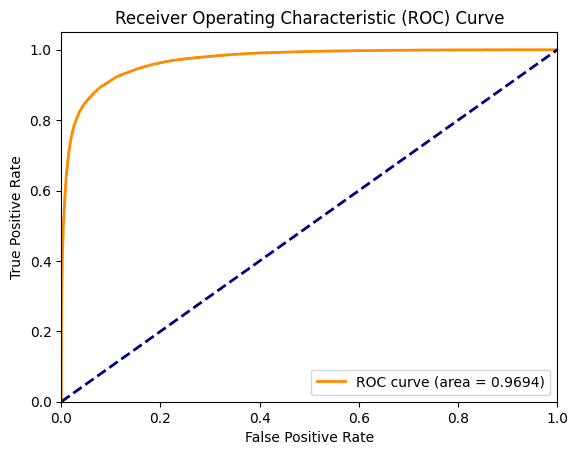

In [ ]:
# 테스트 결과로 AUROC 곡선을 그리기
fpr, tpr, thresholds = roc_curve(combined_gt, combined_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## 시연

In [ ]:
# "is_gt" : 원래 연관이 있었는지를 확인, True -> 새롭게 생성된 link만 확인
#  "k" : pred 값이 높은 순서대로 보여줄 개수
def get_disease_id(combined_pred, combined_gt, combined_edge_index, target_gene_id, is_gt, k = 10):
  result = []
  if target_gene_id is not None:
    gene_index = combined_edge_index[0]
    disease_index = combined_edge_index[1]
    specific_gene_mask = (gene_index == gene_index_map[target_gene_id])

    for i in np.where(specific_gene_mask)[0]:
      result.append([index_disease_map[disease_index[i]], combined_pred[i], combined_gt[i] ])

  # pred 값을 기준으로 내림차순 정렬
  result.sort(key=lambda x: x[1], reverse=True)

  # is_gt 가 True 일때 gt 값이 0인 것만 남기기
  if is_gt == True:
    result = [x for x in result if x[2] != 1.0]

  print(f"Predicted links for gene {target_gene_id} :")
  for index, x in enumerate(result):
    if index == k-1:
      break

    print(f"Disease {x[0]}: Prediction: {x[1]}, Ground Truth: {x[2]}")
  if result == []:
    print("Nothing or not id")

def get_gene_id(combined_pred, combined_gt, combined_edge_index, target_disease_id, is_gt, k = 10):
  result = []
  if target_disease_id is not None:
    gene_index = combined_edge_index[0]
    disease_index = combined_edge_index[1]
    specific_disease_mask = (disease_index == disease_index_map[target_disease_id])

    for i in np.where(specific_disease_mask)[0]:
      result.append([index_gene_map[gene_index[i]], combined_pred[i], combined_gt[i] ])

    # pred 값을 기준으로 내림차순 정렬
    result.sort(key=lambda x: x[1], reverse=True)

    # is_gt 가 True 일때 gt 값이 0인 것만 남기기
    if is_gt == True:
      result = [x for x in result if x[2] != 1.0]

    print(f"Predicted links for Disease {target_disease_id} :")
    for index, x in enumerate(result):
      if index == k-1:
        break

      print(f"Gene {x[0]}: Prediction: {x[1]}, Ground Truth: {x[2]}")
  if result == []:
    print("Nothing or not id")

In [ ]:
target_gene_id = 2  #gene_id
target_disease_id = "C0030567"   #disease_id
get_disease_id(combined_pred, combined_gt,combined_edge_index, target_gene_id,False, 20 )
print()
get_gene_id(combined_pred, combined_gt,combined_edge_index, target_disease_id, True, 10)

Predicted links for gene 2 :
Disease C0002395: Prediction: 0.9954103827476501, Ground Truth: 1.0
Disease C0024121: Prediction: 0.9929471015930176, Ground Truth: 1.0
Disease C0024115: Prediction: 0.9839720726013184, Ground Truth: 1.0
Disease C1565662: Prediction: 0.9565499424934387, Ground Truth: 1.0
Disease C1833104: Prediction: 0.750043511390686, Ground Truth: 0.0
Disease C1970470: Prediction: 0.27458301186561584, Ground Truth: 0.0
Disease C1955871: Prediction: 0.1578100621700287, Ground Truth: 0.0
Disease C0004606: Prediction: 0.1360965520143509, Ground Truth: 1.0
Disease C0033075: Prediction: 0.07732556015253067, Ground Truth: 0.0
Disease C1834034: Prediction: 0.020861119031906128, Ground Truth: 0.0

Predicted links for Disease C0030567 :
Gene 5034: Prediction: 0.9909662008285522, Ground Truth: 0.0
Gene 2123: Prediction: 0.9812263250350952, Ground Truth: 0.0
Gene 84451: Prediction: 0.8627336025238037, Ground Truth: 0.0
Gene 152877: Prediction: 0.8377526998519897, Ground Truth: 0.0
G

# 최적화


===== Starting Repeat 1 for Learning_rates = 0.0010 =====

===== Starting Repeat 2 for Learning_rates = 0.0010 =====

===== Starting Repeat 3 for Learning_rates = 0.0010 =====

===== Starting Repeat 4 for Learning_rates = 0.0010 =====

===== Starting Repeat 5 for Learning_rates = 0.0010 =====
Learning rate = 0.0010, Loss: 0.2466, Train Acc: 0.8993, Val Acc: 0.9004, Test Acc: 0.9026

===== Starting Repeat 1 for Learning_rates = 0.0035 =====

===== Starting Repeat 2 for Learning_rates = 0.0035 =====

===== Starting Repeat 3 for Learning_rates = 0.0035 =====

===== Starting Repeat 4 for Learning_rates = 0.0035 =====

===== Starting Repeat 5 for Learning_rates = 0.0035 =====
Learning rate = 0.0035, Loss: 0.2174, Train Acc: 0.9112, Val Acc: 0.9034, Test Acc: 0.9066

===== Starting Repeat 1 for Learning_rates = 0.0060 =====

===== Starting Repeat 2 for Learning_rates = 0.0060 =====

===== Starting Repeat 3 for Learning_rates = 0.0060 =====

===== Starting Repeat 4 for Learning_rates = 0.006

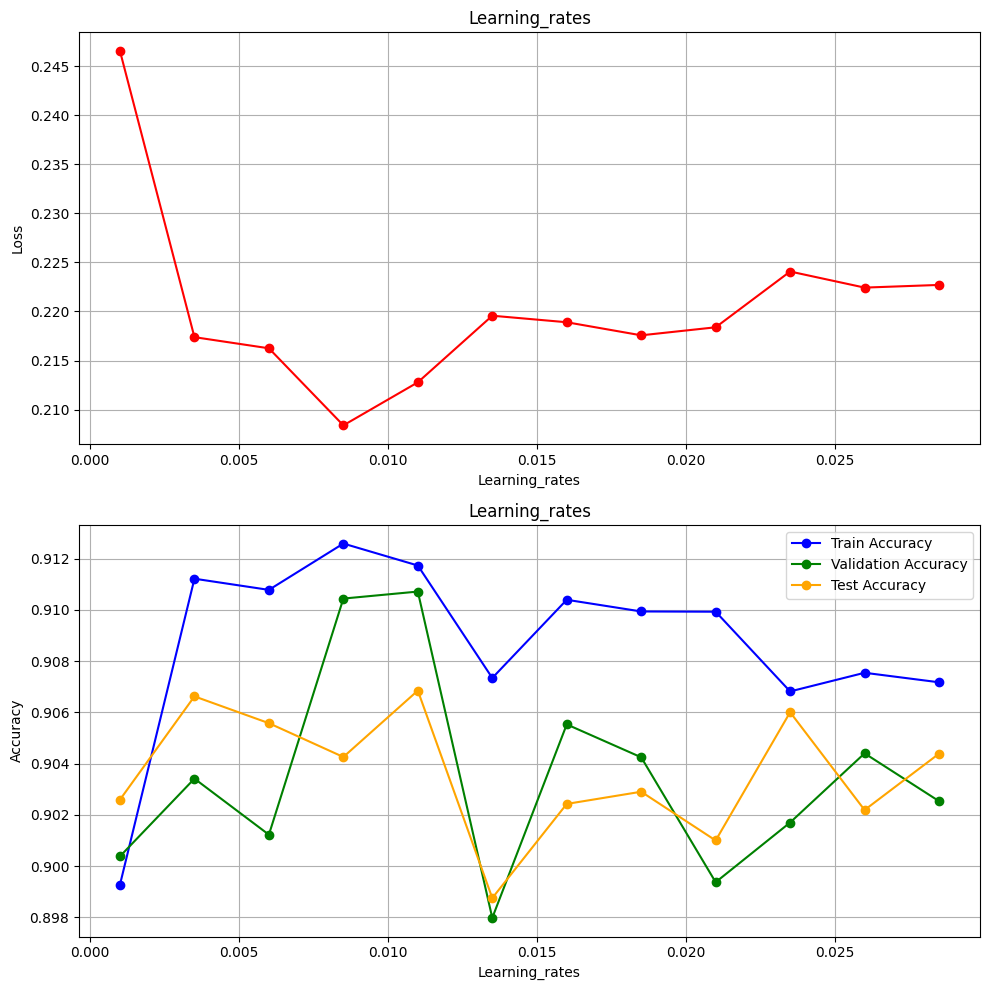

In [ ]:
import torch
import matplotlib.pyplot as plt
import torch_geometric.transforms as T

# neg_sampling_ratio 범위 설정
learning_rate = np.arange(0.001 , 0.03, 0.0025)

# 결과 저장을 위한 딕셔너리 초기화
results_dict = {}

# 반복 횟수 설정 (5번 반복)
n_repeats = 5

# hyperparameter 튜닝 루프
for l_rate in learning_rate:
    # 각 neg_sampling_ratio에 대한 5번 반복 결과 저장 리스트
    all_final_epoch_values = []

    data = HeteroData()

    # 유전자, 질병 노드 추가
    data["gene"].x = torch.tensor(gene.loc[:, gene.columns!="geneId"].values, dtype=torch.float32)
    data["disease"].x = torch.tensor(disease.loc[:, disease.columns!="diseaseId"].values, dtype=torch.float32)

    # id를 인덱스로 변환
    gda_index = pd.DataFrame({"geneIndex" : gda["geneId"].map(gene.set_index("geneId").index.get_loc),
                            "diseaseIndex" : gda["diseaseId"].map(disease.set_index("diseaseId").index.get_loc)}).transpose()

    # 유전자-질병, 질병-유전자 엣지 추가
    data["gene", "associations", "disease"].edge_index = torch.tensor(gda_index.values)
    data = T.ToUndirected()(data)

    # 데이터 분할 (neg_sampling_ratio 변경)
    train_data, val_data, test_data = T.RandomLinkSplit(
        num_val=0.1,
        num_test=0.1,
        is_undirected=True,
        disjoint_train_ratio=0.3,
        neg_sampling_ratio=1.25,
        add_negative_train_samples=True,
        edge_types=[("gene", "associations","disease")],
        rev_edge_types=[("disease", "rev_associations", "gene")]
    )(data)

    # 5번 반복하여 각 epoch 값 저장
    for repeat in range(1, n_repeats + 1):
        print(f"\n===== Starting Repeat {repeat} for Learning_rates = {l_rate:.4f} =====")

        # 모델과 옵티마이저 초기화 (반복마다 새롭게 초기화)
        model = Model(32)
        optimizer = torch.optim.Adam(model.parameters(), lr=l_rate)

        for epoch in range(1, 101):
            loss = train()

            # 마지막 epoch에서 결과 저장
            if epoch == 100:
                train_acc, val_acc, test_acc, train_auroc, val_auroc, test_auroc, combined_pred, combined_gt, combined_edge_index = test()
                final_epoch_values = [loss, train_acc, val_acc, test_acc]
                all_final_epoch_values.append(final_epoch_values)

    # 마지막 epoch 값들의 평균 계산
    mean_final_values = np.mean(all_final_epoch_values, axis=0)
    results_dict[l_rate] = mean_final_values

    print(f"Learning rate = {l_rate:.4f}, Loss: {mean_final_values[0]:.4f}, "
          f"Train Acc: {mean_final_values[1]:.4f}, Val Acc: {mean_final_values[2]:.4f}, Test Acc: {mean_final_values[3]:.4f}")

# 그래프 그리기
Learning_rates = list(results_dict.keys())
loss_vals = [results_dict[k][0] for k in Learning_rates]
train_acc_vals = [results_dict[k][1] for k in Learning_rates]
val_acc_vals = [results_dict[k][2] for k in Learning_rates]
test_acc_vals = [results_dict[k][3] for k in Learning_rates]

plt.figure(figsize=(10, 10))

# Loss 그래프
plt.subplot(2, 1, 1)
plt.plot(Learning_rates, loss_vals, marker='o', label='Loss', color='red')
plt.xlabel('Learning_rates')
plt.ylabel('Loss')
plt.title('Learning_rates')
plt.grid(True)

# Accuracy 그래프
plt.subplot(2, 1, 2)
plt.plot(Learning_rates, train_acc_vals, marker='o', label='Train Accuracy', color='blue')
plt.plot(Learning_rates, val_acc_vals, marker='o', label='Validation Accuracy', color='green')
plt.plot(Learning_rates, test_acc_vals, marker='o', label='Test Accuracy', color='orange')
plt.xlabel('Learning_rates')
plt.ylabel('Accuracy')
plt.title('Learning_rates')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
